#### Includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import altair as alt
from altair import datum
import time
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 5)

In [3]:
from sources import load_dataset, parse_config, setup_model
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase, OrthoKernelBase
from steered_cnn.models import SteeredHemelingNet, HemelingNet
from src.trainer import BinaryClassifierNet

In [163]:
torch.set_printoptions(precision=3, sci_mode=False)

## Orientation Detection

#### Generating a Directional Map

In [154]:
base = SteerableKernelBase.from_steerable(4, oversample=4)

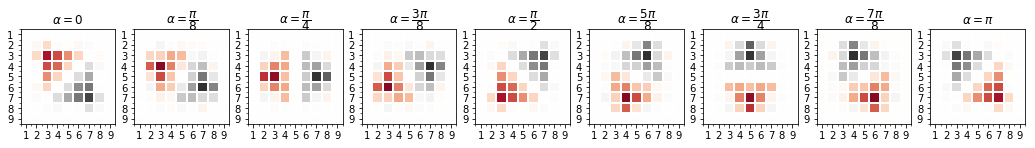

In [155]:
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = (x+y)/4
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}
Wdiamond = base.approximate_weights(K, info)

I = torch.zeros((1,1,9,9))
I[:,:,4,4] = 1
N = 8
fig, axs = plt.subplots(1,N+1)
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
diamond_rot = []
rotations_label = []
for i in range(N+1):
    r = base.conv2d(I,Wdiamond, alpha=alphas[i])[0,0]
    plot_filter(r, plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')
    diamond_rot += [r]
    rotations_label += [repr_pi_fraction(i,N)]
diamond_rot = torch.stack(diamond_rot)

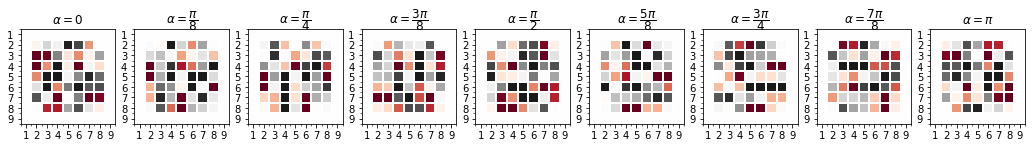

In [156]:
Wnoise = torch.randn(W.shape)

fig, axs = plt.subplots(1,N+1)
noise_rot = []
for i in range(N+1):
    r = base.conv2d(I,Wnoise, alpha=alphas[i])[0,0]
    plot_filter(r, plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')
    noise_rot += [r]
noise_rot = torch.stack(noise_rot)

### Vectorial Attention 

In [119]:
ortho_base = OrthoKernelBase.from_steerable(4, oversample=100)

alpha (rad): tensor([0.000, 0.392, 0.785, 1.179, 1.571, 1.963, 2.356, 2.749, 3.142])
alpha diff (deg): tensor([    0.000,     0.032,     0.000,     0.032,     0.000,     0.032,
            0.000,     0.032,     0.000])
rho: tensor([6.595, 6.527, 6.423, 6.527, 6.595, 6.527, 6.423, 6.527, 6.595])
max alpha diff (deg): 0.03, rho std: 0.0666


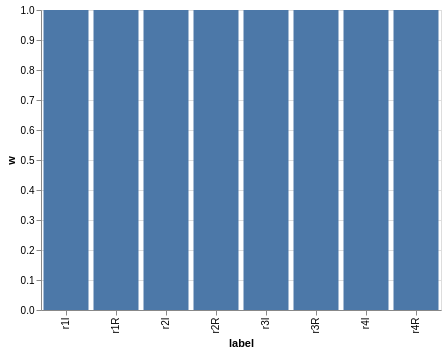

In [164]:
w = torch.ones((1,1,8))#ortho_base.create_weights(1,1)
v = ortho_base.ortho_conv2d(diamond_rot[:,None], w, padding='valid').squeeze()
alpha = torch.atan2(v[1], v[0])
rho = torch.linalg.norm(v, dim=0)
alpha_diff = abs(((alpha-alpha[0])%(2*np.pi))-torch.Tensor(alphas))*180/np.pi

print('alpha (rad):', (alpha-alpha[0])%(2*np.pi))
print('alpha diff (deg):', alpha_diff)
print('rho:', rho)

print(f'max alpha diff (deg): {alpha_diff.max():.2f}, rho std: {rho.std():.4f}')
weights = pd.DataFrame(data=dict(w=w[0,0], label=ortho_base.kernels_label))
alt.Chart(weights).mark_bar().encode(x='label:N', y='w:Q')

alpha (rad): tensor([0.000, 0.332, 0.848, 1.294, 1.571, 1.902, 2.419, 2.865, 3.142])
alpha diff (deg): tensor([    0.000,     3.505,     3.610,     6.648,     0.000,     3.505,
            3.610,     6.648,     0.000])
rho: tensor([1.849, 1.810, 2.000, 1.993, 1.849, 1.810, 2.000, 1.993, 1.849])
max alpha diff (deg): 6.65, rho std: 0.0874


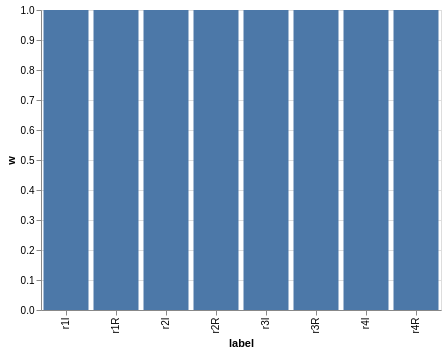

In [165]:
w = torch.ones((1,1,8))#ortho_base.create_weights(1,1)
v = ortho_base.ortho_conv2d(noise_rot[:,None], w, padding='valid').squeeze()
alpha = torch.atan2(v[1], v[0])
rho = torch.linalg.norm(v, dim=0)
alpha_diff = abs(((alpha-alpha[0])%(2*np.pi))-torch.Tensor(alphas))*180/np.pi

print('alpha (rad):', (alpha-alpha[0])%(2*np.pi))
print('alpha diff (deg):', alpha_diff)
print('rho:', rho)

print(f'max alpha diff (deg): {alpha_diff.max():.2f}, rho std: {rho.std():.4f}')
alt.Chart(weights).mark_bar().encode(x='label:N', y='w:Q')